In [3]:
from configobj import ConfigObj
import subprocess
import os, sys
import math
import numpy as np

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from moons1d.spectra import SimSpectrum, Template, Spectra , Sky, Atm_abs
from moons1d.simulator import Simulation
from moons1d.interface import run, run_1obj_allbands, run_1obj_1band

from astropy import units as u
from astropy.constants import c
from astropy.units import Quantity
from math import sqrt, radians, sin, cos, tan, pi, exp

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Markdown
%matplotlib inline 

plt.rcParams['figure.figsize'] = (12,4)
from synphot import SourceSpectrum , SpectralElement, units
from synphot.models import ConstFlux1D, Empirical1D, GaussianFlux1D
import bottleneck as bn

import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout,  GridspecLayout
from IPython.display import display




## Notebook to benchmark Oscar's ETC and moons1d on emission lines

In [5]:
mag_slider = widgets.FloatSlider(
    value=15.5,
    min=10,
    max=25.0,
    step=0.1,
    description='Magnitude:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)


band_drop = widgets.Dropdown(
    options=['I', 'J', 'H'],
    value='I',
    description='Band:',
    disabled=False,
)

vega_check = widgets.Checkbox(
    value=False,
    description='Vega',
    disabled=False,
    indent=False
)

Emi_wave_cell = widgets.BoundedFloatText(
    value=8000,
    min=100,
    max=18000,
    step=20,
    description='Line [A]:',
    disabled=False
)

Emi_flux_cell = widgets.BoundedFloatText(
    value=1.5E-17,
    min=1.5E-20,
    max=1.5E-14,
    step=1.0E-18,
    description='Line flux:',
    disabled=False
)

Emi_width_cell = widgets.BoundedFloatText(
    value=8000,
    min=10,
    max=300,
    step=2,
    description='Line width [A]:',
    disabled=False
)

Source_grid = GridspecLayout(2, 3)
Source_grid[0, 0] = mag_slider
Source_grid[0,2] = vega_check
Source_grid[0,1] = band_drop
Source_grid[1, 0] = Emi_wave_cell
Source_grid[1,2] = Emi_flux_cell
Source_grid[1,1] = Emi_width_cell
display(Source_grid)

Obs_mode_toggle = widgets.ToggleButtons(
    options=['STARE', 'NOD', 'XSWITCH'],
    description='Mode:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

seeing_slider = widgets.FloatSlider(
    value=0.8,
    min=0.6,
    max=1.6,
    step=0.1,
    description='Seeing:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

airmass_slider = widgets.FloatSlider(
    value=1.0,
    min=1.0,
    max=2.0,
    step=0.1,
    description='Airmass:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

Conditions_grid = GridspecLayout(1, 3)
Conditions_grid[0,0]= seeing_slider
Conditions_grid[0,1]= airmass_slider
display(Conditions_grid)

Config_drop = widgets.Dropdown(
    options=['LR', 'HR'],
    value='LR',
    description='Inst Config:',
    disabled=False,
)

SpecConfig_drop = widgets.Dropdown(
    options=['RI', 'YJ','H'],
    value='RI',
    description='Spectral Config:',
    disabled=False,
)

NDIT_cell = widgets.BoundedIntText(
    value=2,
    min=1,
    max=12,
    step=1,
    description='NDIT:',
    disabled=False
)

DIT_cell = widgets.BoundedFloatText(
    value=600,
    min=20,
    max=3600,
    step=20,
    description='DIT[s]:',
    disabled=False
)

Inst_grid = GridspecLayout(3, 2)
Inst_grid[0,0]= Config_drop
Inst_grid[0,1]= SpecConfig_drop
Inst_grid[1,0]= NDIT_cell
Inst_grid[1,1]= DIT_cell
Inst_grid[2,:] = Obs_mode_toggle
display(Inst_grid)


GridspecLayout(children=(FloatSlider(value=15.5, continuous_update=False, description='Magnitude:', layout=Lay…

GridspecLayout(children=(FloatSlider(value=0.8, continuous_update=False, description='Seeing:', layout=Layout(…

GridspecLayout(children=(Dropdown(description='Inst Config:', layout=Layout(grid_area='widget001'), options=('…

[INFO] | GENERATE DISPERSION AXIS:
[INFO] |--- [Wave range]= 6470.000000 - 9340.000000 Angstrom
[INFO] |--- [Spectral Resolution Element]= 1.882143
[INFO] |--- [dispersion]= 0.697090 Angstrom / pix
[INFO] |--- [npix]= 4117.115750 pix
[INFO] | LOAD TELESCOPE TRANSMISSION:
[INFO] |--- [File]= /Users/lovelace/Documents/MOONS_TW/Simulations/moons1d/moons1d/models/Instrument/telescope_eff.txt
[INFO] | LOAD INSTRUMENT TRANSMISSION:
[INFO] |--- [File]= /Users/lovelace/Documents/MOONS_TW/Simulations/moons1d/moons1d/models/Instrument/throughput_RI_worst.txt
[INFO] | LOAD DETECTOR TRANSMISSION:
[INFO] |--- [File]= /Users/lovelace/Documents/MOONS_TW/Simulations/moons1d/moons1d/models/Instrument/QE_LBNL.txt
[INFO] | GENERATE TOTAL TRANSMISSION:
[INFO] |--- Add Instrument [Mean]= 0.271490
[INFO] |--- Add Detector [Mean]= 0.939105
[INFO] |--- Add Telescope [Mean]= 0.607403
[INFO] |--- Add Fibre losses [Mean]= 0.898331
[INFO] |--- Total transmission [Mean]= 0.138876
[INFO] |--- SIMULATING STARE SEQUE

<Figure size 864x288 with 0 Axes>

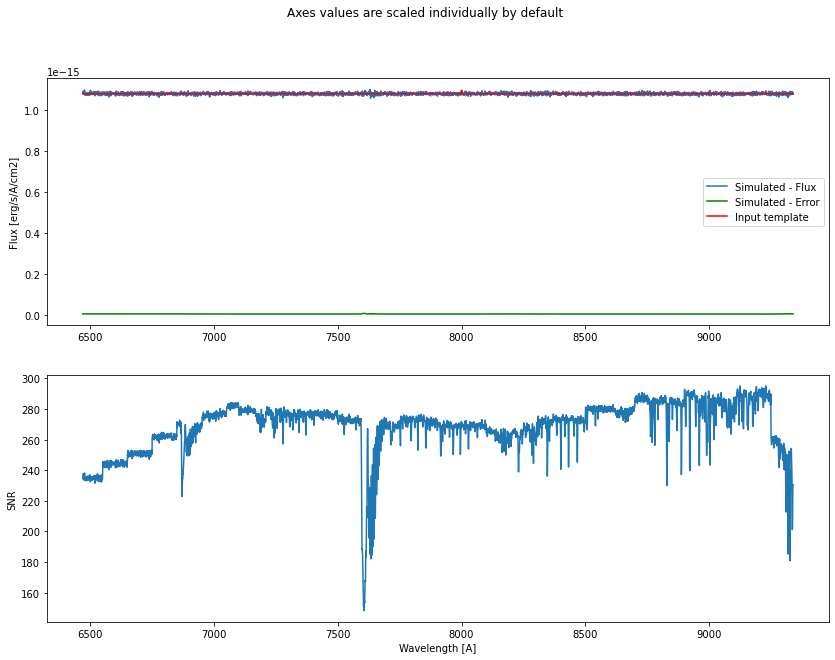

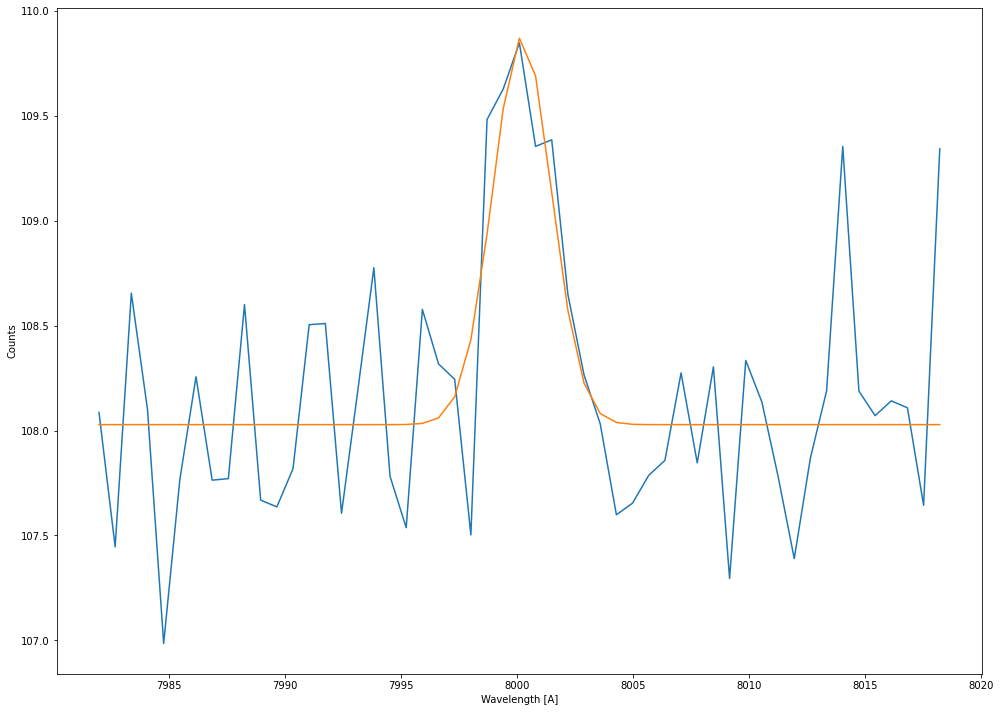

-- Line Properties --
Flux in fitted line = 8.409628
Noise in continuum = 0.761283
line SNR = 11.046648


In [9]:
Photo_bands = [{'name':'I', 'wave_ref' : 0.797, 'vega_cst': 0.45 },{'name':'J', 'wave_ref' : 1.22, 'vega_cst': 0.91 },{'name':'H', 'wave_ref' : 1.63, 'vega_cst': 1.39 }]

#Config path
Path_Inst_config = '../moons1d/models/Instrument/'
Path_template = '../moons1d/models/Science/'
Path_output = '../data/processed/'
Path_filters = '../moons1d/models/synphot/comp/nonhst/'

#Load Configuration files for the instrument parameters
MOONS_modes= ConfigObj(Path_Inst_config + 'MOONS_mode.ini')

#Fill observation dictionnary
Obs_conf= {} 
Obs_conf['OB_name'] = "Continuum+Line"
Obs_conf['observing_mode'] = Obs_mode_toggle.value  #'Nod','Xswitch','Stare'
Obs_conf['airmass'] = airmass_slider.value
Obs_conf['seeing'] = seeing_slider.value
Obs_conf['ndit'] = NDIT_cell.value
Obs_conf['dit'] = DIT_cell.value
Obs_conf['R_mode'] = Config_drop.value
Obs_conf['band'] = SpecConfig_drop.value

Obs_conf['at_corr'] = 1.2
Obs_conf['temperature'] = 11.5 #Temperature [C]
Obs_conf['humidity'] = 14.5 #Relative Humidity [%]
Obs_conf['pressure'] = 743.0 #Pressure [mbar]
#Obs_conf['telescope'] = "VLT"

Ref_band = band_drop.value 
mag = mag_slider.value 

#Use ref AB wavelength for normalisation (no filter)
wave_c = ref =[x for x in Photo_bands if x['name'] == Ref_band][0]['wave_ref'] * 1.0e4 
if vega_check.value :
  mag_type = 'Vega_pivot' # can be 'AB' or 'Vega'
  vega_cst = ref =[x for x in Photo_bands if x['name'] == Ref_band][0]['vega_cst'] 
  mag += vega_cst
else:
  mag_type = 'AB_pivot'

bp = SpectralElement(Empirical1D, points=[wave_c - 10, wave_c, wave_c + 10], lookup_table=[1,1,1], keep_neg=True)
bp.name = Ref_band

#Create source  template
bg = SourceSpectrum(ConstFlux1D, amplitude=1.* units.FLAM)
bg_norm = bg.normalize(mag * u.ABmag, bp, wavelengths = bp.waverange, force=True)
Sig_v = Emi_width_cell.value * u.km / u.s
Sig_l = Sig_v.to(u.AA, equivalencies=u.doppler_optical(Emi_wave_cell.value * u.AA)) - Emi_wave_cell.value * u.AA
em = SourceSpectrum(GaussianFlux1D, mean=Emi_wave_cell.value * u.AA, fwhm=Sig_l,total_flux=Emi_flux_cell.value*u.erg/(u.cm**2 * u.s))
Model_template = bg_norm + em
Model_template.name = 'Emission+Continum'

results = run_1obj_1band(Model_template, 'point-source', mag, mag_type, bp, Obs_conf, atm_disp = True, verbose=True, save_plots = False, save_fits = False, debug = True)


# Compute Line SNR
from lmfit import Model
from lmfit import Parameters, fit_report, minimize


def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2))
  
def line(x, slope, intercept):
    """a line"""
    return slope*x + intercept
    
def constant(x, cst):
    """a line"""
    return 0.*x + cst
  
#Measure SNR in line
# First guess parameters 
Cent = Emi_wave_cell.value 
Sig = Sig_l.value
wave_range = [Cent -7 * Sig, Cent +7 * Sig]
pix_mask = (results.model.wave.value >= wave_range[0]) & (results.model.wave.value <= wave_range[1])
wave = results.model.wave.value[pix_mask]
Obs = results.model.Obs_calibrated.value[pix_mask] / 1E-17
    
Cont = np.average(Obs)
Amp = np.max(Obs)

gmodel = Model(gaussian, prefix='g_') + Model(constant, prefix = 'bg_')
gmodel.set_param_hint('bg_cst', value= Cont)
gmodel.set_param_hint('g_amp', value= Amp * Sig /0.3989,  min=0)
gmodel.set_param_hint('g_cen', value= Cent,  min=Cent - 10, max=Cent + 10)
gmodel.set_param_hint('g_wid', value= Sig,  min= Sig - 5,  max= Sig + 5)

params = gmodel.make_params()    
result = gmodel.fit(Obs, params, x=wave)
#print(fit_report(result))

gauss1 = gaussian(wave, result.params["g_amp"].value, result.params["g_cen"].value, result.params["g_wid"].value)
Flux_res =  np.trapz(gauss1)
Bg_res = result.params["bg_cst"].value
Amp_res = result.params["g_amp"].value
Sig_res = result.params["g_wid"].value
Cent_res = result.params["g_cen"].value
        
plt.figure()
plt.rcParams['figure.figsize'] = (12,4)
plt.plot(wave, Obs, label ="Observations" )
plt.plot(wave, result.best_fit, label ="best fit" )
plt.xlabel("Wavelength [A]")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()

Line_region = np.logical_and(wave > Cent_res -  Sig_res* 3, wave < Cent_res +  Sig_res * 3)
Line_blue = np.logical_and(wave < Cent_res -  Sig_res* 3, wave > Cent_res +  Sig_res * 6)
Line_red = np.logical_and(wave > Cent_res -  Sig_res* 3, wave < Cent_res +  Sig_res * 6)
noise_region = np.logical_or(Line_blue,Line_red)
N_line = np.sum(Line_region)

#Flux_Line_fitted = sqrt(2*pi) * coeff[2]  * coeff[0]
Continuum_Sub_Line = Obs[Line_region].astype(float) - Bg_res
#Flux_Line_obs = integrate.simps(Continuum_Sub_Line, x= lambda_array[Line_region].astype(float)) #Integrated bewteen -=3 sigma
Noise_cont = np.std(Obs[noise_region])
SNR_Line_obs = Flux_res / ( Noise_cont)
print("-- Line Properties --")
print("Flux in fitted line = %f" %(Flux_res))
print("Noise in continuum = %f" %(Noise_cont))
print("line SNR = %f" %(SNR_Line_obs))

